In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

logs = # TO FILL
graph_dir = f"{logs}/graphs/accuracy"
processed_log_dir = f"{logs}/resultats_11-23_processed"
save_dir = f"{processed_log_dir}/dlrm/"
log_dir = f"{logs}/resultats_11-23/"
path = f"{log_dir}/dlrm/"

job_file = save_dir+"/summary.csv"
energy_file = save_dir+"/energy.csv"
energy = pd.read_csv(energy_file).drop(columns=["Unnamed: 0"])

/var/folders/yq/7v824pz907x0d1tjqclbqmn80000gn/T/ipykernel_58179/339790997.py:8: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  energy = pd.read_csv(energy_file).drop(columns=["Unnamed: 0"])


In [2]:
jobs = pd.read_csv(job_file).drop(columns=["Unnamed: 0"])

In [3]:
len(jobs)

25

In [4]:
jobs.columns

Index(['job', 'energy_kWh', 'energy_joule',
       'energy_consumption_since_previous_measurement_milliJ', 'job_id',
       'file', 'start_time_ms', 'end_time_ms', 'epoch_nb', 'block_nb',
       'eval_nb', 'mllog_submission_benchmark', 'mllog_submission_org',
       'mllog_submission_division', 'mllog_submission_status',
       'mllog_submission_platform', 'mllog_eval_samples',
       'mllog_global_batch_size', 'mllog_opt_base_learning_rate',
       'mllog_sgd_opt_base_learning_rate',
       'mllog_sgd_opt_learning_rate_decay_poly_power',
       'mllog_opt_learning_rate_warmup_steps',
       'mllog_opt_learning_rate_warmup_factor', 'mllog_lr_decay_start_steps',
       'mllog_sgd_opt_learning_rate_decay_steps',
       'mllog_gradient_accumulation_steps', 'mllog_eval_accuracy',
       'mllog_tracked_stats', 'mllog_train_samples', 'node_nb'],
      dtype='object')

In [5]:
jobs["total_batch_size"]=jobs["mllog_global_batch_size"]*jobs["node_nb"]*8


In [6]:
job_list = list(jobs[~jobs["job"].isin([126279,126280,126281,126282,126283])].job_id)

In [7]:
job_list

[126295,
 126296,
 126297,
 126298,
 126299,
 126300,
 126301,
 126302,
 126303,
 126304,
 126305,
 126306,
 126307,
 126308,
 126309,
 126310,
 126311,
 126312,
 126313,
 126314]

/var/folders/yq/7v824pz907x0d1tjqclbqmn80000gn/T/ipykernel_58179/1946986461.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lib_df["timestamp(sec)"] = (lib_df["timestamp"]-lib_df["timestamp"].min())*1e-3


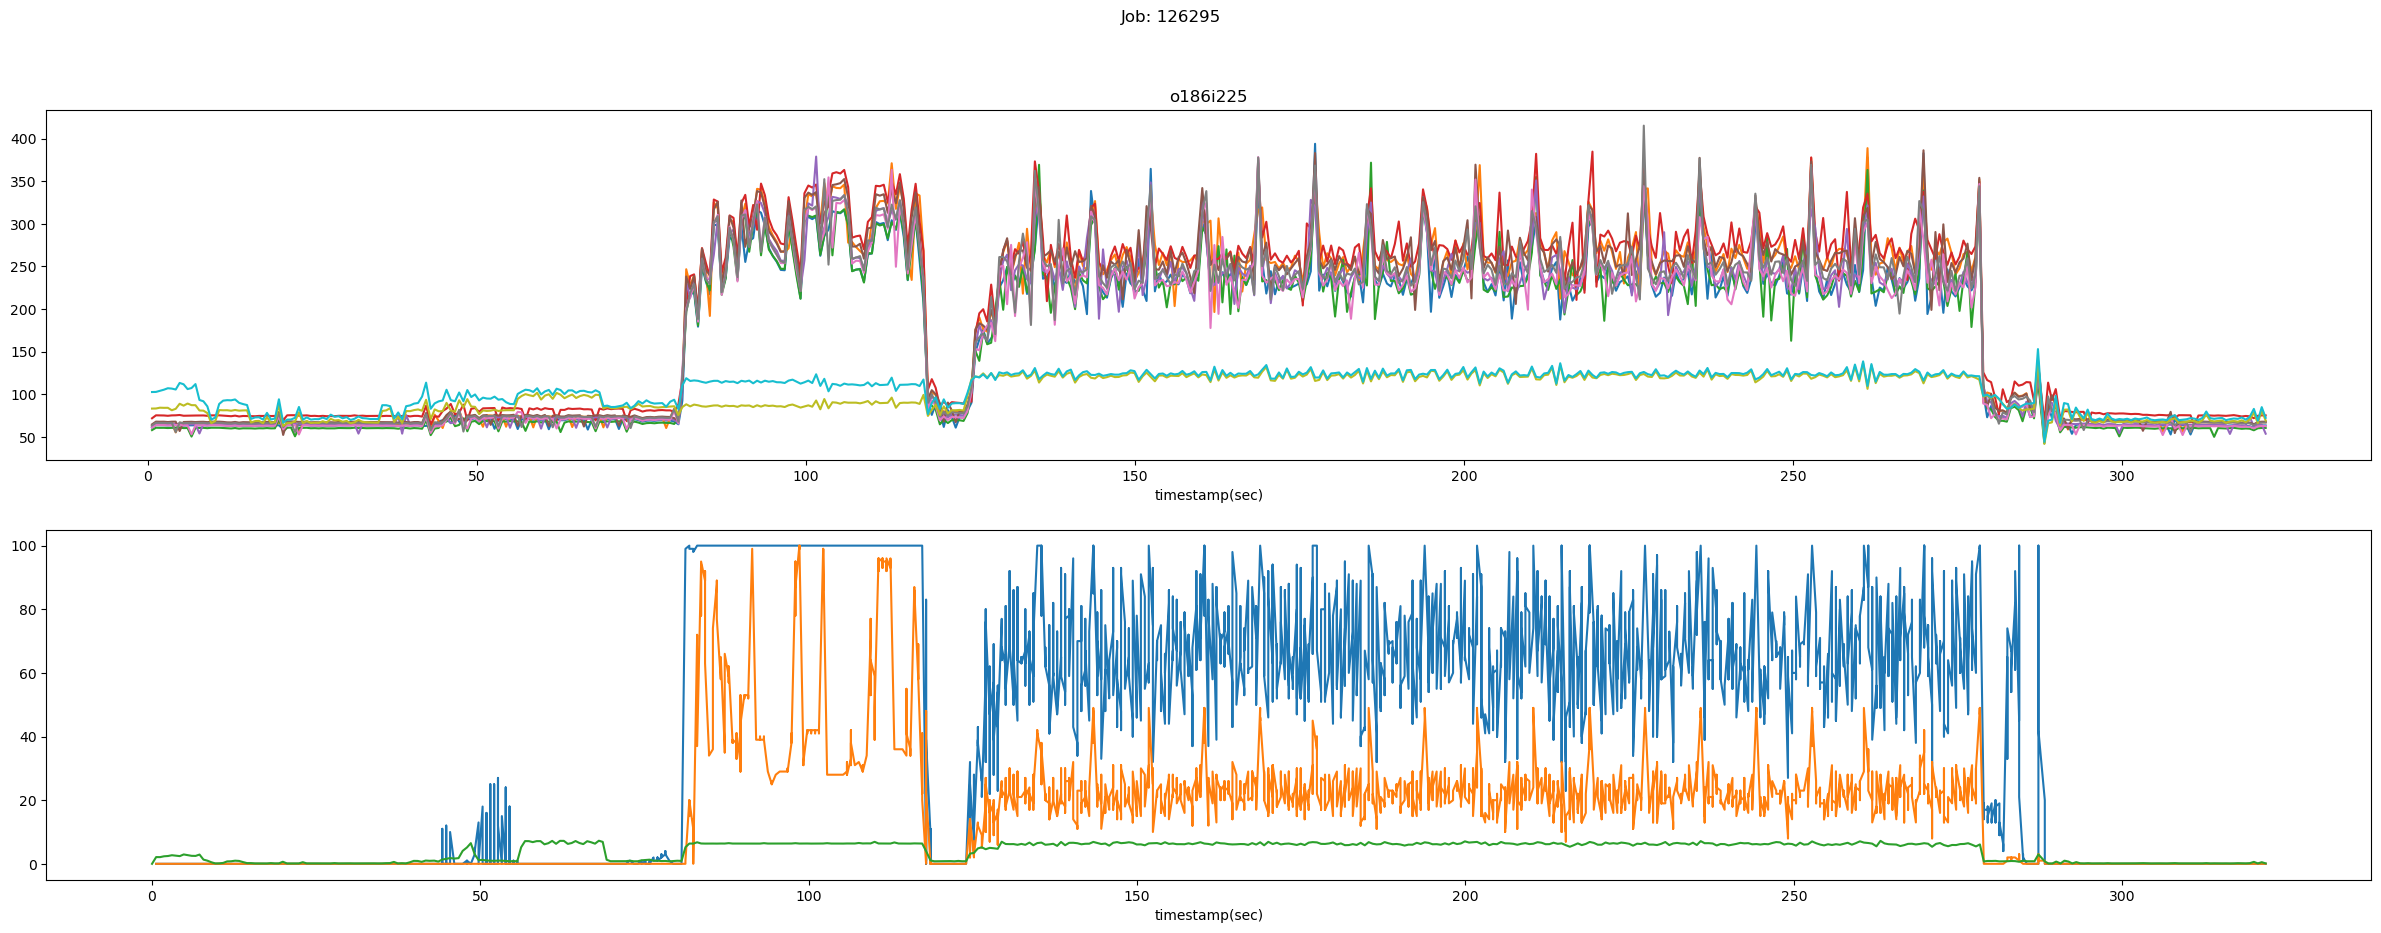

In [8]:
def plot_energy_components(ax ,energy_df, node, energy_col, legend=False):
    for label, df in energy_df.groupby(["device_index"]):
        df.plot(
            x="timestamp(sec)", 
            y=energy_col, 
            ax=ax, 
            label="GPU energy "+str(label),
            )
    for label, df in energy_df.groupby(["domain", "socket"]):
        df.plot(
            x="timestamp(sec)", 
            y=energy_col, 
            ax=ax, 
            label=label,
            )
    if legend:
        ax.legend(
            bbox_to_anchor=(0.5,-0.1), 
            loc='upper center',
            fontsize=20,
            ncol=2
        )
    else:
        ax.get_legend().remove()
    ax.set_title(node)
    return ax

def plot_utilization(ax, plot_df):
    plot_df[
        (plot_df["device_index"].notna())
        
        ].plot(x="timestamp(sec)", y="global_utilization_percent", ax=ax, label="GPU utilization")
    plot_df[
        (plot_df["device_index"].notna())
        ].plot(x="timestamp(sec)", y="global_memory_percent", ax=ax, label="GPU mem utilization")
    plot_df[
        (plot_df["utilization_percent"].notna())
        ].groupby("timestamp(sec)").mean().plot(ax=ax, y="utilization_percent", label="CPU avg utilization")
    # ax.legend(
    #     bbox_to_anchor=(0.5,-0.1), 
    #     loc='upper center',
    #     fontsize=20,
    #     ncol=2
    # )
    ax.get_legend().remove()
    return ax

for job in job_list[:1]:
    lib_df = energy[energy["job"]==job]
    lib_df["timestamp(sec)"] = (lib_df["timestamp"]-lib_df["timestamp"].min())*1e-3
    diff_df = lib_df.groupby("timestamp(sec)").first().reset_index()[["timestamp(sec)"]].diff()
    diff_df.rename(columns={"timestamp(sec)":"diff"}, inplace=True)
    diff_df["timestamp(sec)"] = lib_df.groupby("timestamp(sec)").first().reset_index()[["timestamp(sec)"]]
    lib_df = lib_df.merge(diff_df, on="timestamp(sec)")
    lib_df["power(W)"]=lib_df["energy_consumption_since_previous_measurement_milliJ"]*10**(-3)/lib_df["diff"] 
    
    energy_job = lib_df.copy()
    
    nodes = energy_job.node.unique()
    node_nb = len(nodes)
    batch = jobs[jobs["job"]==job][["total_batch_size"]].values[0]
    fig, ax = plt.subplots(2, node_nb, figsize=(30,10))
    for i, node in enumerate(nodes):
        ax1 = ax[0,i] if node_nb>1 else ax[0]
        ax2 = ax[1,i] if node_nb>1 else ax[1]
        plot_df = energy_job[energy_job["node"]==node]
        avg_df = plot_df[["timestamp(sec)", 'power(W)', "device_index", "domain", "socket", "global_utilization_percent", "global_memory_percent", "utilization_percent"]].copy()
        # avg_df['mov_avg'] = plot_df["energy_consumption_since_previous_measurement_milliJ"].rolling(1).sum()
        # avg_df["timestamp"] = (plot_df["timestamp"]-plot_df["timestamp"].min())*1e-3
        plot_energy_components(ax1, avg_df, node, 'power(W)')
        plot_utilization(ax2, avg_df)
    plt.suptitle(f"Job: {job}")

In [9]:
power = pd.DataFrame()
for job in job_list[-10:]:
    power_job = pd.DataFrame()
    energy_job = energy[energy["job"]==job]
    ecol = "energy_consumption_since_previous_measurement_milliJ"
    
    power_job = energy_job[energy_job[ecol].notna()].groupby("timestamp").sum()[[ecol, "job"]].reset_index()
    power_job["timestamp(sec)"] = (power_job["timestamp"]-power_job["timestamp"].min())*1e-3
    power_job["power(W)"]=power_job[ecol]*1e-3/power_job["timestamp(sec)"].diff()
    
    power = pd.concat([power, power_job])


In [10]:
power

,timestamp,energy_consumption_since_previous_measurement_milliJ,job,timestamp(sec),power(W)
0,1699291130352,437059.206299,1263050,0.000,NaN
1,1699291130950,433638.768311,1263050,0.598,725.148442
2,1699291131551,436353.725342,1263050,1.199,726.046132
3,1699291132151,438235.334595,1263050,1.799,730.392224
4,1699291132749,433374.579346,1263050,2.397,724.706654
...,...,...,...,...,...
534,1699320505392,416678.216431,1263140,322.464,695.623066
535,1699320505991,407914.200195,1263140,323.063,680.991987
536,1699320506592,408921.124390,1263140,323.664,680.401205
537,1699320507195,422060.472168,1263140,324.267,699.934448


/Users/mathildepro/miniforge3/envs/energy_analysis/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mathildepro/miniforge3/envs/energy_analysis/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mathildepro/miniforge3/envs/energy_analysis/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x800 with 0 Axes>

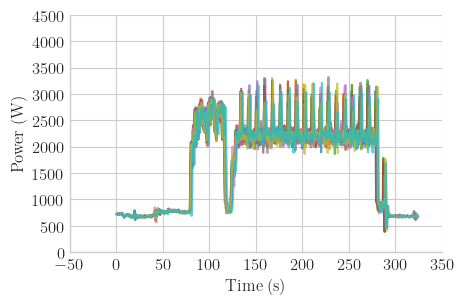

In [22]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.style.use('seaborn-v0_8-whitegrid')

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.rcParams.update(tex_fonts)

plt.figure(figsize=(15,8))
ax = sns.relplot(
    x="timestamp(sec)", 
    y="power(W)", 
    data=power.reset_index(), 
    hue="job", kind="line", 
    palette="tab10",
    height=3, aspect=12/8,alpha=0.7,
    )
# ax.set(title="Power consumption of dlrm training")
ax._legend.remove()
FONTSIZE = 12
ax.set(ylim=(0, 4500))
ax.set_xlabels("Time (s)", fontsize=FONTSIZE)
ax.set_ylabels("Power (W)", fontsize=FONTSIZE)
ax.set_xticklabels(fontsize=FONTSIZE)
ax.set_yticklabels(fontsize=FONTSIZE)
graph_dir = "/Users/mathildepro/Documents/code_projects/hpe_logs/graphs/power"
ax.savefig(f"{graph_dir}/dlrm.png", bbox_inches='tight', dpi=300)
ax.savefig(f"{graph_dir}/dlrm.pdf", bbox_inches='tight', dpi=300)

In [12]:
power = pd.DataFrame()
ilo_power = pd.DataFrame()
for job in job_list[-10:]:
    power_job = pd.DataFrame()
    energy_job = energy[energy["job"]==job]
    ecol = "energy_consumption_since_previous_measurement_milliJ"
    
    power_job = energy_job[energy_job[ecol].notna()].groupby("timestamp").sum()[[ecol, "job"]].reset_index()
    power_job["timestamp(sec)"] = (power_job["timestamp"]-power_job["timestamp"].min())*1e-3
    power_job["power(W)"]=power_job[ecol]*1e-3/power_job["timestamp(sec)"].diff()   
    
    power = pd.concat([power, power_job])
    
    ilo_path = f"/Users/mathildepro/Documents/code_projects/hpe_logs/resultats_nov/dlrm/{job}/o186i225/ilo_power.csv" 
    ilo = pd.read_csv(ilo_path)
    ilo["job"]=job
    ilo["timestamp(sec)"] = (ilo["timestamp"]-power_job["timestamp"].min()*1e-3)
    ilo_power = pd.concat([ilo_power, ilo]) 

In [13]:
min = 150
max = 250
avg_power = power[(power["timestamp(sec)"]>min)&(power["timestamp(sec)"]<max)].groupby(["job"])["power(W)"].mean().reset_index()
avg_ilo_power = ilo_power[(ilo_power["timestamp(sec)"]>min)&(ilo_power["timestamp(sec)"]<max)].groupby(["job"])["power_watt"].mean().reset_index()


In [14]:
avg_power.agg(["mean", "std"])

,job,power(W)
mean,1.263095e+06,2265.265825
std,3.027650e+01,11.034766


In [15]:
avg_ilo_power.agg(["mean", "std"])

,job,power_watt
mean,126309.50000,2738.712222
std,3.02765,44.626116


In [16]:
avg_power = power.groupby(["job"])["power(W)"].mean().reset_index()
avg_ilo_power = ilo_power.groupby(["job"])["power_watt"].mean().reset_index()


In [17]:
avg_power.agg(["mean", "std"])

,job,power(W)
mean,1.263095e+06,1664.886098
std,3.027650e+01,4.998021


In [18]:
avg_ilo_power.agg(["mean", "std"])

,job,power_watt
mean,126309.50000,2140.660606
std,3.02765,40.131947


[Text(0.5, 1.0, 'Power consumption of dlrm training')]

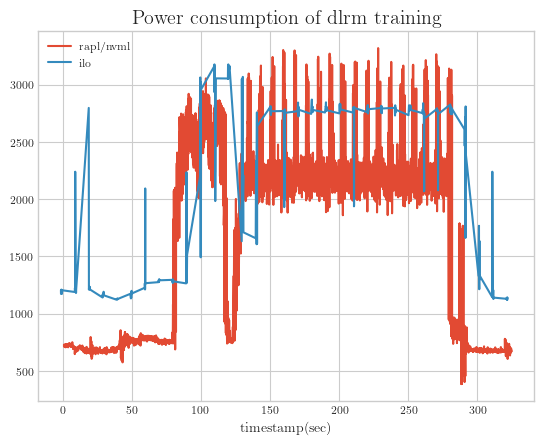

In [19]:
fig, ax = plt.subplots()
data = power.groupby(["job", "timestamp(sec)"]).mean().reset_index().sort_values(by="timestamp(sec)")
# sns.relplot(ax=ax, x="timestamp(sec)", y="power(W)", data=data, kind="line", label="rapl/nvml",height=6, aspect=15/8)
data.plot(ax=ax, x="timestamp(sec)", y="power(W)", label="rapl/nvml")
data = ilo_power.groupby(["job", "timestamp(sec)"]).mean().reset_index().sort_values(by="timestamp(sec)")
# sns.relplot(ax=ax, x="timestamp(sec)", y="power_watt", data=data, kind="line", label="ilo",height=6, aspect=15/8)
data.plot(ax=ax, x="timestamp(sec)", y="power_watt", label="ilo")
ax.set(title="Power consumption of dlrm training")
# ax._legend.remove()

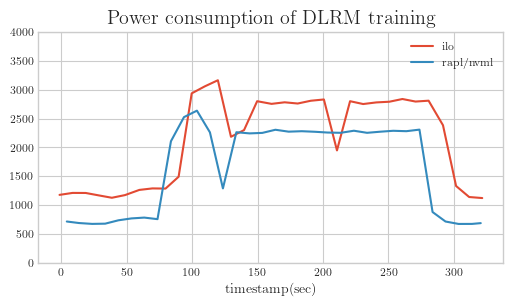

In [29]:
fig, ax = plt.subplots(figsize=(6,3))
jobid = 0

data = ilo_power[ilo_power["job"]==ilo_power["job"].values[jobid]]
data_ilo = data.set_index(pd.to_datetime(data["timestamp"], unit="s")).rename(columns={"timestamp":"coucou"}).drop(columns=["coucou"])
data_ilo.resample("10s").mean()
# data = ilo_power[ilo_power["job"]==ilo_power["job"].values[jobid]].groupby(["timestamp(sec)"]).mean().reset_index().sort_values(by="timestamp(sec)")
# sns.relplot(ax=ax, x="timestamp(sec)", y="power_watt", data=data_ilo, kind="line", label="ilo",height=6, aspect=15/8)
data_ilo.plot(ax=ax, x="timestamp(sec)", y="power_watt", label="ilo")

data = power[power["job"]==power["job"].values[jobid]]
data = data.set_index(pd.to_datetime(data["timestamp"], unit="ms")).rename(columns={"timestamp":"coucou"}).drop(columns=["coucou"])
data_power = data.resample("10s", origin=data_ilo.index[0]).mean()
# data_power = data_power.groupby(["timestamp(sec)"]).mean().reset_index().sort_values(by="timestamp(sec)") # "job", 
# sns.relplot(ax=ax, x="timestamp(sec)", y="power(W)", data=data_power, kind="line", label="rapl/nvml",height=6, aspect=15/8)
data_power.plot(ax=ax, x="timestamp(sec)", y="power(W)", label="rapl/nvml")

ax.set(title="Power consumption of DLRM training")
ax.set_ylim(0, 4000)
plt.savefig(f"{graph_dir}/ilo_dlrm.png", dpi=300)
plt.savefig(f"{graph_dir}/ilo_dlrm.pdf", dpi=300)
# ax._legend.remove()